In [5]:
import pandas as pd

In [6]:

df = pd.read_csv('our-bma.csv')


In [7]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGCCGACCTCGGAATGCGGTCCCATCCACGTTT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAAGTCCCACGGCAAGCAACTCTTGATCCCCACCTCAAGAGGT...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGAACGCCCGCAGCGACCCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCGCAGAAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTTTGACC...


In [8]:
from tqdm import tqdm


In [9]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [10]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [11]:
import difflib


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [13]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 87337.85it/s]


[5, 37, 107, 191, 275, 344, 378, 491, 536, 648, 690, 813, 850, 939, 1016, 1099, 1167, 1261, 1331, 1369, 1485, 1531, 1544, 1665, 1728, 1802, 1872, 1879, 1968, 2051, 2105, 2179, 2209, 2270, 2373, 2404, 2469, 2508, 2593, 2660, 2639, 2701, 2802, 2801, 2847, 2932, 2965, 3012, 3079, 3147, 3134, 3210, 3238, 3302, 3493, 3423, 3336, 3266, 3209, 3209, 3111, 3054, 3002, 3014, 2947, 2902, 2784, 2762, 2724, 2612, 2568, 2534, 2433, 2380, 2360, 2269, 2188, 2189, 2110, 2028, 2006, 1904, 1865, 1776, 1759, 1611, 1629, 1503, 1467, 1407, 1351, 1232, 1170, 1109, 1038, 990, 911, 814, 751, 669, 573, 541, 467, 378, 303, 228, 160, 91, 21, 0]


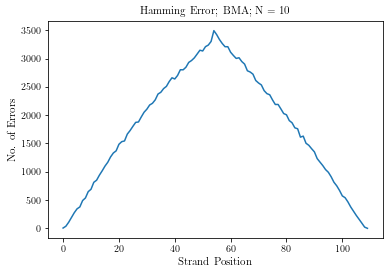

In [14]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-our-bma-hamming.pdf', bbox_inches='tight')

In [15]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:08<00:00, 1170.99it/s]


In [16]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> GTC 6
T -> AGG 6
G -> AAAA 6
 -> TTC 6
TCA ->  6
 -> TTA 6
AC -> G 6
T -> AAAA 6
ATG ->  6
CTC ->  6
AT -> G 6
 -> TGT 6
 -> ACT 6
CGC ->  6
 -> AGG 6
C -> AT 7
CGT ->  7
TAG ->  7
GTC ->  7
 -> GGC 7
AGC ->  7
TAT ->  7
ACG ->  7
AT -> C 7
 -> TCT 7
 -> AGA 7
T -> GGA 7
A -> GGG 7
GAC ->  7
 -> CTC 7
 -> ATA 7
 -> TAT 7
A -> TG 8
 -> GCT 8
C -> GGG 8
A -> GC 8
TT -> C 8
AGA ->  8
TA -> C 8
 -> ATC 8
CGA ->  8
TGT ->  8
 -> ACG 8
 -> AAAA 8
CAT ->  8
 -> TAC 8
G -> CT 8
 -> CGC 9
ACT ->  9
C -> GA 9
TAC ->  9
CT -> G 9
TGA ->  9
CTG ->  9
 -> CGA 10
 -> TGG 10
GCA ->  10
TA -> G 10
 -> GTT 10
CG -> A 10
 -> GCA 10
 -> GCG 10
TCG ->  10
ATC ->  10
 -> AGC 10
 -> ACA 11
TGC ->  11
 -> GCC 11
A -> TC 11
 -> TTG 11
CAG ->  11
 -> TGC 11
 -> TAA 11
 -> CTT 12
 -> GGA 12
TC -> A 12
 -> CTA 12
TG -> C 12
GCT ->  12
 -> CCT 12
A -> CCC 12
 -> AAT 12
 -> ACC 12
A -> CT 12
A -> GT 12
 -> ATT 12
C -> AG 13
 -> GGT 13
T -> GGG 13
AG -> C 14
GC -> A 14
G -> TC 14
C -> TA 14
 -> CAC 15
GAT ->  1

A -> G @ 41 6
 -> G @ 23 6
 -> G @ 19 6
 -> G @ 104 6
A -> T @ 87 6
AC ->  @ 54 6
 -> G @ 13 6
A -> CC @ 55 6
A -> G @ 79 6
A -> T @ 95 6
A -> G @ 27 6
T -> G @ 95 6
 -> C @ 42 6
 -> C @ 94 6
T -> A @ 50 6
 -> A @ 12 6
 -> A @ 13 6
 -> A @ 3 6
T -> A @ 58 6
TT ->  @ 55 6
 -> A @ 7 6
 -> A @ 84 6
 -> A @ 89 6
A -> G @ 49 6
 -> AAG @ 54 6
 -> AC @ 52 6
 -> AG @ 52 6
 -> C @ 103 6
 -> C @ 105 6
 -> C @ 108 6
 -> C @ 12 6
 -> C @ 27 6
TG ->  @ 56 6
TG ->  @ 55 6
 -> G @ 30 6
 -> C @ 7 6
 -> C @ 91 6
 -> CC @ 57 6
 -> G @ 31 6
 -> G @ 87 6
 -> G @ 6 6
A -> C @ 18 6
A -> C @ 16 6
 -> T @ 31 6
A -> C @ 105 6
 -> T @ 48 6
 -> T @ 49 6
T -> G @ 102 6
 -> T @ 62 6
 -> T @ 69 6
 -> T @ 72 6
T -> G @ 104 6
 -> T @ 16 6
 -> T @ 79 6
 -> T @ 81 6
 -> T @ 83 6
T -> G @ 14 6
T -> G @ 29 6
 -> T @ 89 6
 -> T @ 93 6
 -> T @ 96 6
T -> G @ 7 6
 -> T @ 98 6
 -> TA @ 52 6
T -> G @ 87 6
 -> T @ 80 6
A -> C @ 29 6
A -> C @ 35 6
A -> C @ 37 6
A -> C @ 9 6
 -> G @ 84 6
 -> G @ 86 6
A -> T @ 63 6
A -> C @ 82 6
A

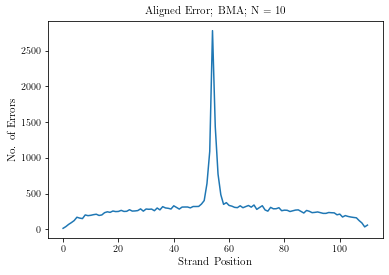

In [17]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 10', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov10-our-bma-aligned.pdf', bbox_inches='tight')

In [18]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [19]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [20]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 9, 13, 14, 21, 30, 21, 28, 36, 24, 34, 36, 34, 20, 31, 30, 40, 28, 26, 31, 29, 34, 35, 37, 35, 34, 39, 28, 37, 37, 43, 31, 42, 37, 40, 38, 47, 34, 42, 29, 49, 31, 33, 34, 46, 33, 38, 39, 40, 34, 42, 37, 52, 47, 119, 123, 54, 35, 46, 37, 38, 36, 44, 38, 31, 31, 34, 59, 38, 48, 41, 45, 31, 38, 37, 56, 30, 37, 37, 38, 27, 24, 32, 27, 42, 33, 32, 26, 37, 37, 31, 34, 33, 33, 27, 26, 37, 37, 28, 25, 27, 30, 35, 37, 23, 32, 20, 17, 16, 10, 14]
[0, 9, 8, 17, 14, 23, 17, 22, 20, 25, 33, 20, 22, 25, 19, 34, 28, 27, 29, 30, 29, 27, 28, 18, 31, 21, 23, 29, 36, 20, 24, 38, 37, 31, 28, 23, 36, 28, 36, 34, 33, 31, 25, 34, 26, 33, 26, 28, 38, 32, 33, 30, 27, 43, 113, 124, 40, 28, 18, 47, 35, 34, 27, 23, 37, 38, 39, 44, 44, 33, 26, 23, 30, 23, 23, 29, 43, 26, 36, 24, 31, 34, 30, 29, 23, 39, 28, 26, 35, 29, 21, 23, 29, 30, 27, 26, 28, 25, 25, 21, 26, 21, 21, 21, 21, 12, 16, 21, 12, 5, 6]
[0, 3, 2, 7, 7, 12, 12, 9, 11, 8, 10, 14, 14, 15, 17, 16, 12, 15, 21, 12, 11, 16, 17, 19, 14, 21, 22, 16, 12, 22,

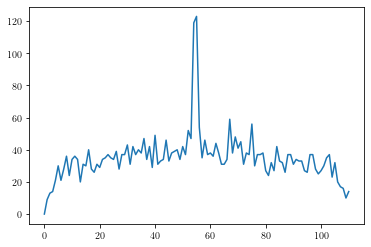

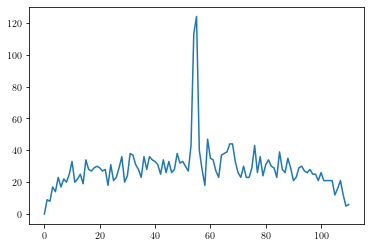

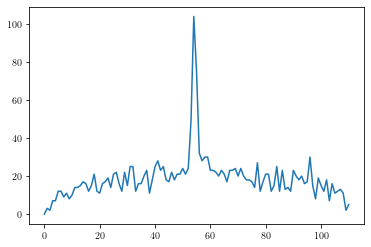

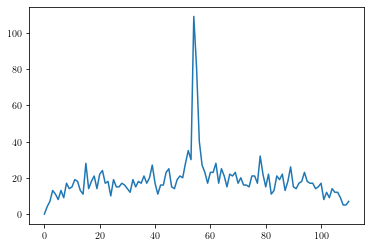

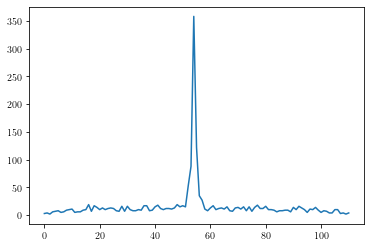

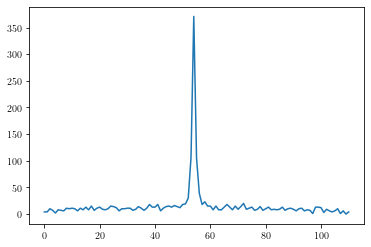

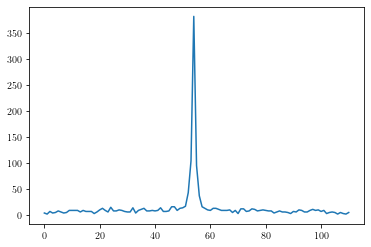

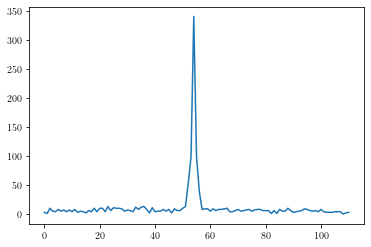

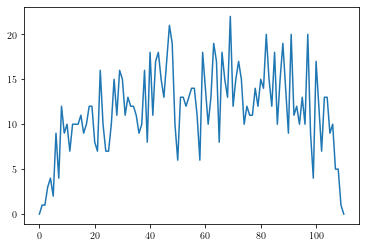

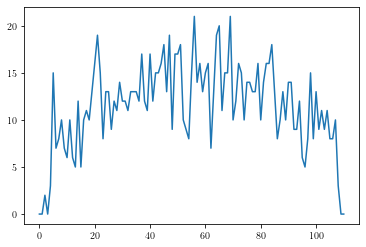

In [21]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [22]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)